In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

# Load dataset
df = pd.read_csv("rolling_news_data.csv", parse_dates=["Date"])

# Define financial features
financial_features = [
    "Close", "High", "Low", "Open", "Volume",
    "SMA_20", "SMA_50", "EMA_20", "RSI_14", "MACD",
    "BB_High", "BB_Low", "ATR", "ROC_10",
    "Log_Returns", "Cumulative_Returns",
    "Quantile_10", "Quantile_50", "Quantile_90",
    "Quantile_10.1", "Quantile_50.1", "Quantile_90.1",
    "Quantile_10.2", "Quantile_50.2", "Quantile_90.2"
]

# Define news embedding features
news_features = [col for col in df.columns if "embed_" in col]

# Verify feature separation
print(f"Financial Features: {len(financial_features)}")
print(f"News Features: {len(news_features)}")


Financial Features: 25
News Features: 768


In [3]:
# Initialize MinMaxScalers
financial_scaler = MinMaxScaler()
news_scaler = MinMaxScaler()

# Scale financial features
df[financial_features] = financial_scaler.fit_transform(df[financial_features])

# Scale news embeddings
df[news_features] = news_scaler.fit_transform(df[news_features])

# Save scalers
joblib.dump(financial_scaler, "financial_scaler.pkl")
joblib.dump(news_scaler, "news_scaler.pkl")

# Save processed dataset
df.to_csv("scaled_minmax_financial_news.csv", index=False)
print("Dataset saved with MinMaxScaler")


Dataset saved with MinMaxScaler


In [6]:
# Reload dataset
df = pd.read_csv("scaled_minmax_financial_news.csv", parse_dates=["Date"])

# Define input features (excluding 'Date' and 'Close' as target)
feature_cols = [col for col in df.columns if col not in ["Date", "Close"]]

# Convert to numpy arrays
X_data = df[feature_cols].values
y_data = df["Close"].values  # Target

# Function to create sequences
def create_sequences(data, target, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 5  # Past 5 days for prediction
X_seq, y_seq = create_sequences(X_data, y_data, seq_length)

print(f"LSTM Data Shape: X={X_seq.shape}, y={y_seq.shape}")


LSTM Data Shape: X=(5544, 5, 792), y=(5544,)


In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define train-test split (80% training, 20% testing)
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"Train-Test Split: {X_train.shape[0]} train, {X_test.shape[0]} test")


Train-Test Split: 4435 train, 1109 test


In [9]:
import torch.nn as nn
import torch.optim as optim

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Initialize model
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(X_train.shape[2]).to(device)

print(f"LSTM Model initialized on {device}")


LSTM Model initialized on mps


In [11]:
# Define loss function & optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# Training loop
epochs = 1000
best_loss = float("inf")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

    scheduler.step(epoch_loss)

    # Save best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), "best_lstm_model.pth")
        print(f"Model saved at epoch {epoch+1} with best loss {best_loss:.6f}")

print("LSTM Training Complete!")


Epoch 1/1000, Loss: 0.010454
Model saved at epoch 1 with best loss 0.010454
Epoch 2/1000, Loss: 0.001161
Model saved at epoch 2 with best loss 0.001161
Epoch 3/1000, Loss: 0.000310
Model saved at epoch 3 with best loss 0.000310
Epoch 4/1000, Loss: 0.000291
Model saved at epoch 4 with best loss 0.000291
Epoch 5/1000, Loss: 0.000221
Model saved at epoch 5 with best loss 0.000221
Epoch 6/1000, Loss: 0.000186
Model saved at epoch 6 with best loss 0.000186
Epoch 7/1000, Loss: 0.000196
Epoch 8/1000, Loss: 0.000180
Model saved at epoch 8 with best loss 0.000180
Epoch 9/1000, Loss: 0.000164
Model saved at epoch 9 with best loss 0.000164
Epoch 10/1000, Loss: 0.000173
Epoch 11/1000, Loss: 0.000168
Epoch 12/1000, Loss: 0.000169
Epoch 13/1000, Loss: 0.000106
Model saved at epoch 13 with best loss 0.000106
Epoch 14/1000, Loss: 0.000128
Epoch 15/1000, Loss: 0.000118
Epoch 16/1000, Loss: 0.000154
Epoch 17/1000, Loss: 0.000125
Epoch 18/1000, Loss: 0.000105
Model saved at epoch 18 with best loss 0.0001

In [16]:
# Load original dataset
df_original = pd.read_csv("rolling_news_data.csv", parse_dates=["Date"])

# Fit MinMaxScaler only on 'Close' prices
close_scaler = MinMaxScaler()
df_original["Close"] = close_scaler.fit_transform(df_original[["Close"]])

# Save Close price scaler
joblib.dump(close_scaler, "close_scaler.pkl")
print("Close price scaler saved")


# Load trained model
model.load_state_dict(torch.load("best_lstm_model.pth", map_location=device))
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.to(device))

# Convert predictions to numpy
y_pred = y_pred_tensor.cpu().numpy().flatten()
y_true = y_test_tensor.cpu().numpy().flatten()

# Load the correct Close price scaler
close_scaler = joblib.load("close_scaler.pkl")

# Apply inverse transformation ONLY to Close prices
y_pred_original = close_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_original = close_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# Print corrected sample predictions
for i in range(10):
    print(f"Actual: {y_true_original[i]:.2f}, Predicted: {y_pred_original[i]:.2f}")




Close price scaler saved
Actual: 143.35, Predicted: 102.82
Actual: 141.77, Predicted: 103.27
Actual: 141.77, Predicted: 103.24
Actual: 141.77, Predicted: 103.69
Actual: 141.17, Predicted: 104.26
Actual: 141.17, Predicted: 104.61
Actual: 141.17, Predicted: 105.12
Actual: 141.17, Predicted: 105.20
Actual: 138.90, Predicted: 105.40
Actual: 138.90, Predicted: 104.53


/var/folders/bl/qygrpx515yn2jk1zq7j95d_80000gp/T/ipykernel_65688/1013954707.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_

In [17]:
# Load trained model
model.load_state_dict(torch.load("best_lstm_model.pth", map_location=device))
model.eval()

# Make predictions
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor.to(device))

# Convert predictions to numpy
y_pred = y_pred_tensor.cpu().numpy().flatten()
y_true = y_test_tensor.cpu().numpy().flatten()

# Load the correct Close price scaler
close_scaler = joblib.load("close_scaler.pkl")

# Apply inverse transformation ONLY to Close prices
y_pred_original = close_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_original = close_scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()

# Print corrected sample predictions
for i in range(10):
    print(f"Actual: {y_true_original[i]:.2f}, Predicted: {y_pred_original[i]:.2f}")


Actual: 143.35, Predicted: 102.82
Actual: 141.77, Predicted: 103.27
Actual: 141.77, Predicted: 103.24
Actual: 141.77, Predicted: 103.69
Actual: 141.17, Predicted: 104.26
Actual: 141.17, Predicted: 104.61
Actual: 141.17, Predicted: 105.12
Actual: 141.17, Predicted: 105.20
Actual: 138.90, Predicted: 105.40
Actual: 138.90, Predicted: 104.53


/var/folders/bl/qygrpx515yn2jk1zq7j95d_80000gp/T/ipykernel_65688/218570500.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_lstm_mo

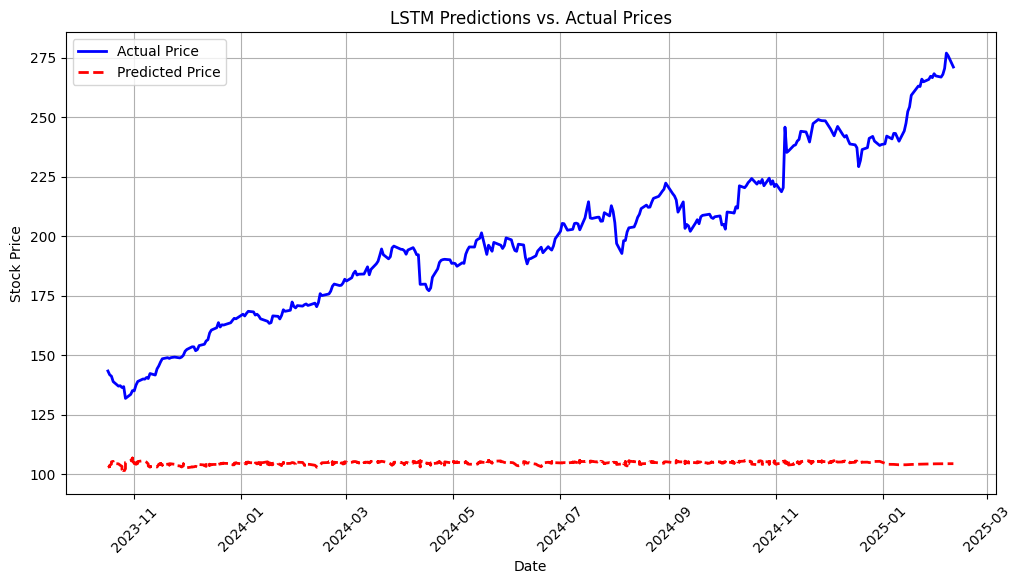

In [19]:
import matplotlib.pyplot as plt

# Create a date range for visualization
dates = df["Date"].iloc[-len(y_true_original):]  # Select last `y_test` dates

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, y_true_original, label="Actual Price", color="blue", linewidth=2)
plt.plot(dates, y_pred_original, label="Predicted Price", color="red", linestyle="dashed", linewidth=2)

# Labels and styling
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Predictions vs. Actual Prices")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()



In [21]:
import numpy as np

# Check min-max values of predictions & actuals
print(f"🔹 Actual Price Range: Min={np.min(y_true_original):.2f}, Max={np.max(y_true_original):.2f}")
print(f"🔹 Predicted Price Range: Min={np.min(y_pred_original):.2f}, Max={np.max(y_pred_original):.2f}")

# Compute mean and standard deviation
actual_mean, actual_std = np.mean(y_true_original), np.std(y_true_original)
predicted_mean, predicted_std = np.mean(y_pred_original), np.std(y_pred_original)

print(f"📊 Actual Mean: {actual_mean:.2f}, Std Dev: {actual_std:.2f}")
print(f"📉 Predicted Mean: {predicted_mean:.2f}, Std Dev: {predicted_std:.2f}")


🔹 Actual Price Range: Min=131.84, Max=276.90
🔹 Predicted Price Range: Min=100.47, Max=106.79
📊 Actual Mean: 198.66, Std Dev: 29.57
📉 Predicted Mean: 104.77, Std Dev: 0.59
